# Diffusion Model Evaluation Notebook

This notebook provides a comprehensive evaluation pipeline for the AIA2STIX diffusion model:
1. Generate visibilities using the diffusion model
2. Visualize predicted vs true visibilities
3. Load and apply the visibility refiner
4. Use the FCD model to reconstruct images from visibilities
5. Compare all results

## Setup and Imports

In [1]:
import os
import sys
from pathlib import Path
import time

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from tqdm import tqdm
import yaml

# Add training directory to path
training_dir = Path('/mnt/nas05/data01/francesco/AIA2STIX/training')
sys.path.append(str(training_dir))

# Import custom modules
from src.data.dataset import get_aia2stix_data_objects
from train_encoder_to_visibility import EncoderToVisibilityModel
from util import generate_samples
from src.modules import VisibilityRefiner, CompositeLoss
import src as K

# For FCD model
try:
    os.environ["KERAS_BACKEND"] = "tensorflow"  # Set backend
    import keras
    import huggingface_hub
    KERAS_AVAILABLE = True
    print("✅ Keras and HuggingFace Hub available")
except ImportError as e:
    print(f"⚠️ Warning: {e}")
    KERAS_AVAILABLE = False

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set matplotlib colormap
import matplotlib
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 150

/mnt/nas05/data01/francesco/AIA2STIX/training/src/vit.py:26: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa
2025-09-07 12:23:44.100854: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-07 12:23:44.100951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-07 12:23:44.441917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-07 12:23:45.151540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to 

✅ Keras and HuggingFace Hub available
Using device: cpu


## Configuration and Paths

In [2]:
# Model paths - UPDATE THESE PATHS TO YOUR ACTUAL MODEL LOCATIONS
DIFFUSION_MODEL_PATH = "/mnt/nas05/data01/francesco/AIA2STIX/saved_models/model_aia_2_stix_very_very_small_v2/model_epoch_0995.pth"
DIFFUSION_CONFIG_PATH = "/mnt/nas05/data01/francesco/AIA2STIX/training/configs/very_very_small_model.json"
REFINER_MODEL_PATH = "/mnt/nas05/data01/francesco/AIA2STIX/training/checkpoints/refiner_very_very_small/checkpoint_epoch_1000.pth"
REFINER_CONFIG_PATH = "/mnt/nas05/data01/francesco/AIA2STIX/training/configs/refiner_config_mse.yaml"

# Data paths
DATA_PATH = "/mnt/nas05/astrodata01/aia_2_stix/prepro_data_20250731_210359/processed_images"
VIS_PATH = "/mnt/nas05/data01/francesco/AIA2STIX/Flarelist_visibilites.csv"
ENC_DATA_PATH = "/mnt/nas05/astrodata01/aia_2_stix/encoded_data/"  # Update this path

# Evaluation parameters
BATCH_SIZE = 8
NUM_SAMPLES = 5  # Number of samples to evaluate
SEED = 42

# Set random seed
torch.manual_seed(SEED)
np.random.seed(SEED)

print("Configuration loaded")

Configuration loaded


## Load Dataset

In [24]:
# Load validation dataset
print("Loading validation dataset...")
dataset, _, dataloader = get_aia2stix_data_objects(
    vis_path=VIS_PATH,
    data_path=DATA_PATH,
    batch_size=BATCH_SIZE,
    distributed=False,
    num_data_workers=4,
    split='valid',
    seed=SEED,
    enc_data_path=ENC_DATA_PATH
)

print(f"Dataset size: {len(dataset)}")
print(f"Number of batches: {len(dataloader)}")

# Get a sample batch to understand the data structure
sample_batch = next(iter(dataloader))
print(f"Batch structure:")
for i, item in enumerate(sample_batch):
    print(f"  Item {i}: shape {item.shape}, dtype {item.dtype}")

Loading validation dataset...
Dataset size: 57
Number of batches: 7
Batch structure:
  Item 0: shape torch.Size([8, 1, 256, 256]), dtype torch.float32
  Item 1: shape torch.Size([8, 24, 2]), dtype torch.float32
  Item 2: shape torch.Size([8, 24, 2]), dtype torch.float32


## Load Diffusion Model

In [5]:
# Load diffusion model configuration
print("Loading diffusion model...")

# Load config
config = K.config.load_config(DIFFUSION_CONFIG_PATH)
# print(f"Config loaded: {config['model_config']['name']}")

# Create model
inner_model = K.config.make_model(config)
inner_model_ema = K.config.make_model(config)  # EMA model

# Load checkpoint
checkpoint = torch.load(DIFFUSION_MODEL_PATH, map_location=device)
inner_model.load_state_dict(checkpoint['model'])
inner_model_ema.load_state_dict(checkpoint['model_ema'])

# Create denoiser wrapper
model = K.config.make_denoiser_wrapper(config)(inner_model).to(device)
model_ema = K.config.make_denoiser_wrapper(config)(inner_model_ema).to(device)

model_ema.eval()

print(f"✅ Diffusion model loaded (epoch: {checkpoint.get('epoch', 'unknown')})")
print(f"Model parameters: {sum(p.numel() for p in model_ema.parameters()):,}")

Loading diffusion model...
✅ Diffusion model loaded (epoch: 995)
Model parameters: 30,443


## Generate Visibilities with Diffusion Model

In [34]:
# Get a batch for testing
test_batch = next(iter(dataloader))
aia_data = test_batch[0].contiguous().float().to(device)
true_vis = test_batch[1].to(device).reshape(-1, 1, 24, 2)
enc_vis = test_batch[2].to(device).reshape(-1, 1, 24, 2)

step=1000

print(f"Batch shapes:")
print(f"  AIA data: {aia_data.shape}")
print(f"  True visibilities: {true_vis.shape}")
print(f"  Encoded visibilities: {enc_vis.shape}")

# Generate samples using the diffusion model
print("Generating visibilities with diffusion model...")
with torch.no_grad():
    start_time = time.time()
    samples = generate_samples(
        model_ema,
        aia_data.shape[0],
        device,
        cond_label=None,
        sampler="dpmpp_2m_sde",
        cond_img=enc_vis,
        step=step,
    )
    generation_time = time.time() - start_time
    
    predicted_vis = samples.reshape(-1, 24, 2)
    true_vis_reshaped = true_vis.reshape(-1, 24, 2)

print(f"✅ Generated {predicted_vis.shape[0]} visibility predictions in {generation_time:.2f}s")
print(f"Predicted visibilities shape: {predicted_vis.shape}")

Batch shapes:
  AIA data: torch.Size([8, 1, 256, 256])
  True visibilities: torch.Size([8, 1, 24, 2])
  Encoded visibilities: torch.Size([8, 1, 24, 2])
Generating visibilities with diffusion model...


  0%|          | 0/1000 [00:00<?, ?it/s]

✅ Generated 8 visibility predictions in 2.46s
Predicted visibilities shape: torch.Size([8, 24, 2])


/home2/francesco/.conda/envs/sdo_project/lib/python3.10/site-packages/torchsde/_brownian/brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.009999996051192284 and t0=0.01.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")


## Utility Functions

In [26]:
def chi_square_distance(pred_vis, true_vis):
    """Calculate chi-square distance between predicted and true visibilities."""
    if isinstance(pred_vis, torch.Tensor):
        pred_vis = pred_vis.detach().cpu().numpy()
    if isinstance(true_vis, torch.Tensor):
        true_vis = true_vis.detach().cpu().numpy()
        
    pred_flat = pred_vis.reshape(-1)
    true_flat = true_vis.reshape(-1)
    
    epsilon = 1e-8
    chi_sq = np.sum((pred_flat - true_flat)**2 / (np.abs(true_flat) + epsilon))
    return chi_sq

def plot_visibility_comparison(pred_vis, true_vis, title_prefix="", chi_sq_dist=None, sample_idx=0):
    """Plot comprehensive visibility comparison."""
    # Convert to numpy if needed
    if isinstance(pred_vis, torch.Tensor):
        pred_vis = pred_vis.detach().cpu().numpy()
    if isinstance(true_vis, torch.Tensor):
        true_vis = true_vis.detach().cpu().numpy()
    
    # Select sample if batch
    if len(pred_vis.shape) > 2:
        pred_vis = pred_vis[sample_idx]
        true_vis = true_vis[sample_idx]
    
    # Calculate chi-square if not provided
    if chi_sq_dist is None:
        chi_sq_dist = chi_square_distance(pred_vis, true_vis)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot real parts
    axes[0, 0].plot(pred_vis[:, 0], 'b-', label='Predicted Real', linewidth=2)
    axes[0, 0].plot(true_vis[:, 0], 'r--', label='True Real', linewidth=2)
    axes[0, 0].set_title('Real Part Comparison')
    axes[0, 0].set_xlabel('Visibility Index')
    axes[0, 0].set_ylabel('Real Value')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot imaginary parts
    axes[0, 1].plot(pred_vis[:, 1], 'b-', label='Predicted Imag', linewidth=2)
    axes[0, 1].plot(true_vis[:, 1], 'r--', label='True Imag', linewidth=2)
    axes[0, 1].set_title('Imaginary Part Comparison')
    axes[0, 1].set_xlabel('Visibility Index')
    axes[0, 1].set_ylabel('Imaginary Value')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot amplitude comparison
    pred_amp = np.sqrt(pred_vis[:, 0]**2 + pred_vis[:, 1]**2)
    true_amp = np.sqrt(true_vis[:, 0]**2 + true_vis[:, 1]**2)
    axes[1, 0].plot(pred_amp, 'b-', label='Predicted Amplitude', linewidth=2)
    axes[1, 0].plot(true_amp, 'r--', label='True Amplitude', linewidth=2)
    axes[1, 0].set_title('Amplitude Comparison')
    axes[1, 0].set_xlabel('Visibility Index')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot phase comparison
    pred_phase = np.arctan2(pred_vis[:, 1], pred_vis[:, 0])
    true_phase = np.arctan2(true_vis[:, 1], true_vis[:, 0])
    axes[1, 1].plot(pred_phase, 'b-', label='Predicted Phase', linewidth=2)
    axes[1, 1].plot(true_phase, 'r--', label='True Phase', linewidth=2)
    axes[1, 1].set_title('Phase Comparison')
    axes[1, 1].set_xlabel('Visibility Index')
    axes[1, 1].set_ylabel('Phase (radians)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add overall title with chi-square distance
    title = f'{title_prefix}Visibility Comparison'
    if chi_sq_dist is not None:
        title += f' - Chi-square Distance: {chi_sq_dist:.6f}'
    
    fig.suptitle(title, fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return fig

print("✅ Utility functions defined")

✅ Utility functions defined


## Visualize Diffusion Model Results

Chi-square distance for sample 0: 81.461693


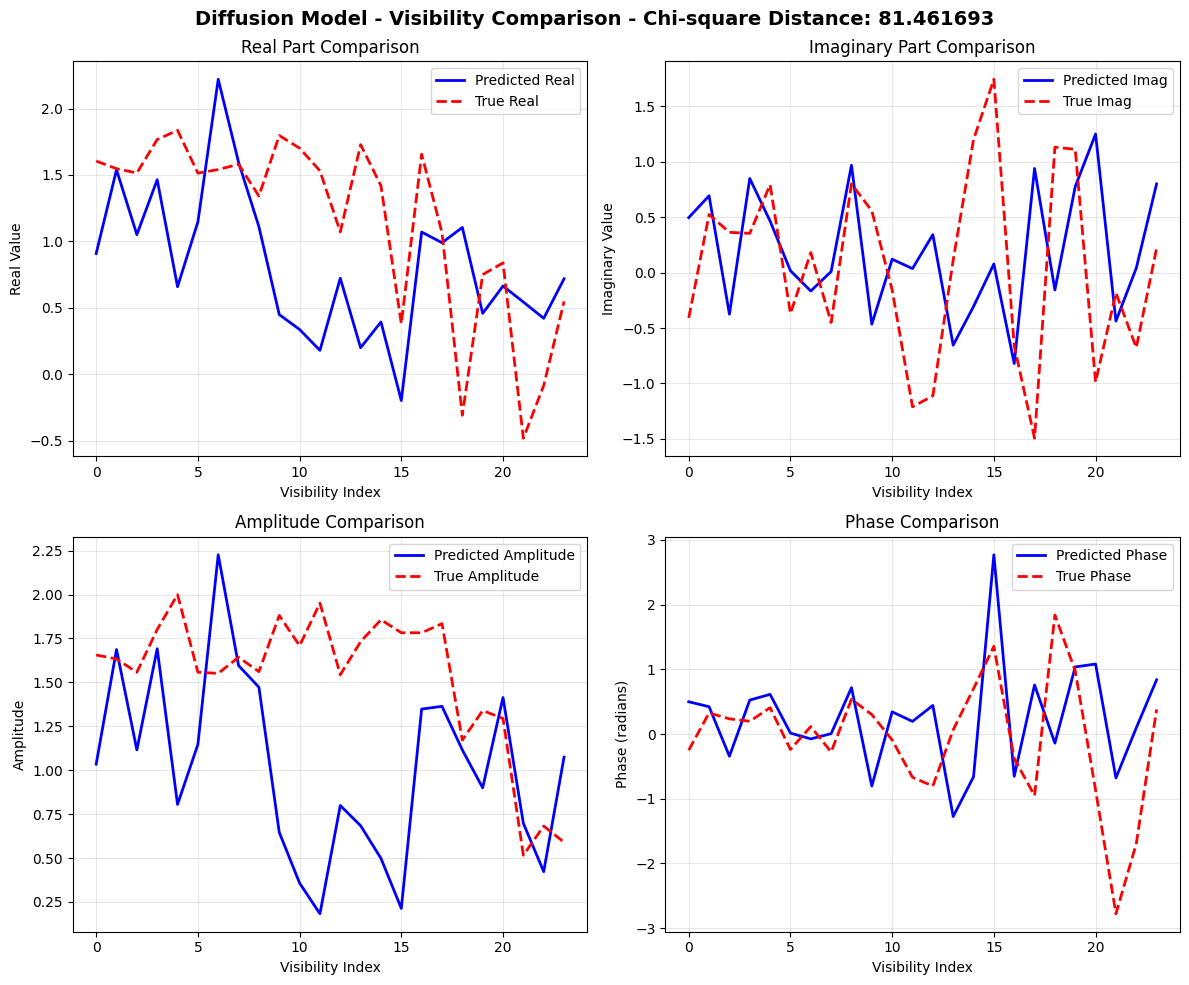


Diffusion Model Statistics:
Predicted visibilities range: [-1.324340, 2.652929]
True visibilities range: [-1.957633, 1.997051]
MSE: 0.877665
MAE: 0.700696


In [37]:
# Calculate chi-square distance
chi_sq_dist = chi_square_distance(predicted_vis[0], true_vis_reshaped[0])
print(f"Chi-square distance for sample 0: {chi_sq_dist:.6f}")

# Plot the comparison for the first sample
plot_visibility_comparison(
    predicted_vis[1], 
    true_vis_reshaped[1], 
    title_prefix="Diffusion Model - ",
    chi_sq_dist=chi_sq_dist
)

# Print statistics
print(f"\nDiffusion Model Statistics:")
print(f"Predicted visibilities range: [{predicted_vis.min():.6f}, {predicted_vis.max():.6f}]")
print(f"True visibilities range: [{true_vis_reshaped.min():.6f}, {true_vis_reshaped.max():.6f}]")
print(f"MSE: {F.mse_loss(predicted_vis, true_vis_reshaped).item():.6f}")
print(f"MAE: {F.l1_loss(predicted_vis, true_vis_reshaped).item():.6f}")

## Load Visibility Refiner

In [29]:
# Load refiner configuration
print("Loading visibility refiner...")

with open(REFINER_CONFIG_PATH, 'r') as f:
    refiner_config = yaml.safe_load(f)

# Create refiner model
refiner_model = VisibilityRefiner(
    input_dim=refiner_config['model']['input_dim'],
    hidden_dims=refiner_config['model']['hidden_dims'],
    output_dim=refiner_config['model']['output_dim'],
    dropout_rate=refiner_config['model']['dropout_rate'],
    use_residual=refiner_config['model']['use_residual']
).to(device)

# Load refiner checkpoint
refiner_checkpoint = torch.load(REFINER_MODEL_PATH, map_location=device)
refiner_model.load_state_dict(refiner_checkpoint['model_state_dict'])
refiner_model.eval()

print(f"✅ Refiner model loaded (epoch: {refiner_checkpoint.get('epoch', 'unknown')})")
print(f"Refiner parameters: {sum(p.numel() for p in refiner_model.parameters()):,}")
print(f"Model architecture: {refiner_config['model']['hidden_dims']}")
print(f"Loss configuration: {refiner_config['loss']}")

Loading visibility refiner...
✅ Refiner model loaded (epoch: 999)
Refiner parameters: 197,296
Model architecture: [512, 256, 128]
Loss configuration: {'type': 'mse', 'epsilon': '1e-8'}


## Apply Refiner to Diffusion Results

In [38]:
# Prepare diffusion outputs for refiner (flatten to 48 dimensions)
diffusion_vis_flat = predicted_vis.view(-1, 48)  # (batch, 48)
true_vis_flat = true_vis_reshaped.view(-1, 48)

print(f"Input shapes for refiner:")
print(f"  Diffusion visibilities: {diffusion_vis_flat.shape}")
print(f"  True visibilities: {true_vis_flat.shape}")

# Apply refiner
print("Refining visibilities...")
with torch.no_grad():
    refined_vis_flat = refiner_model(diffusion_vis_flat)
    
# Reshape back to (batch, 24, 2)
refined_vis = refined_vis_flat.view(-1, 24, 2)

print(f"✅ Refined {refined_vis.shape[0]} visibility predictions")
print(f"Refined visibilities shape: {refined_vis.shape}")

# Calculate improvement
chi_sq_before = chi_square_distance(predicted_vis[0], true_vis_reshaped[0])
chi_sq_after = chi_square_distance(refined_vis[0], true_vis_reshaped[0])
improvement = ((chi_sq_before - chi_sq_after) / chi_sq_before * 100)

print(f"\nRefiner Performance:")
print(f"Chi-square before refining: {chi_sq_before:.6f}")
print(f"Chi-square after refining:  {chi_sq_after:.6f}")
print(f"Improvement: {improvement:.2f}%")

mse_before = F.mse_loss(predicted_vis, true_vis_reshaped).item()
mse_after = F.mse_loss(refined_vis, true_vis_reshaped).item()
print(f"MSE before refining: {mse_before:.6f}")
print(f"MSE after refining:  {mse_after:.6f}")
print(f"MSE improvement: {((mse_before - mse_after) / mse_before * 100):.2f}%")

Input shapes for refiner:
  Diffusion visibilities: torch.Size([8, 48])
  True visibilities: torch.Size([8, 48])
Refining visibilities...
✅ Refined 8 visibility predictions
Refined visibilities shape: torch.Size([8, 24, 2])

Refiner Performance:
Chi-square before refining: 81.461693
Chi-square after refining:  20208.531250
Improvement: -24707.41%
MSE before refining: 0.877665
MSE after refining:  122.869560
MSE improvement: -13899.60%


## Visualize Refiner Results

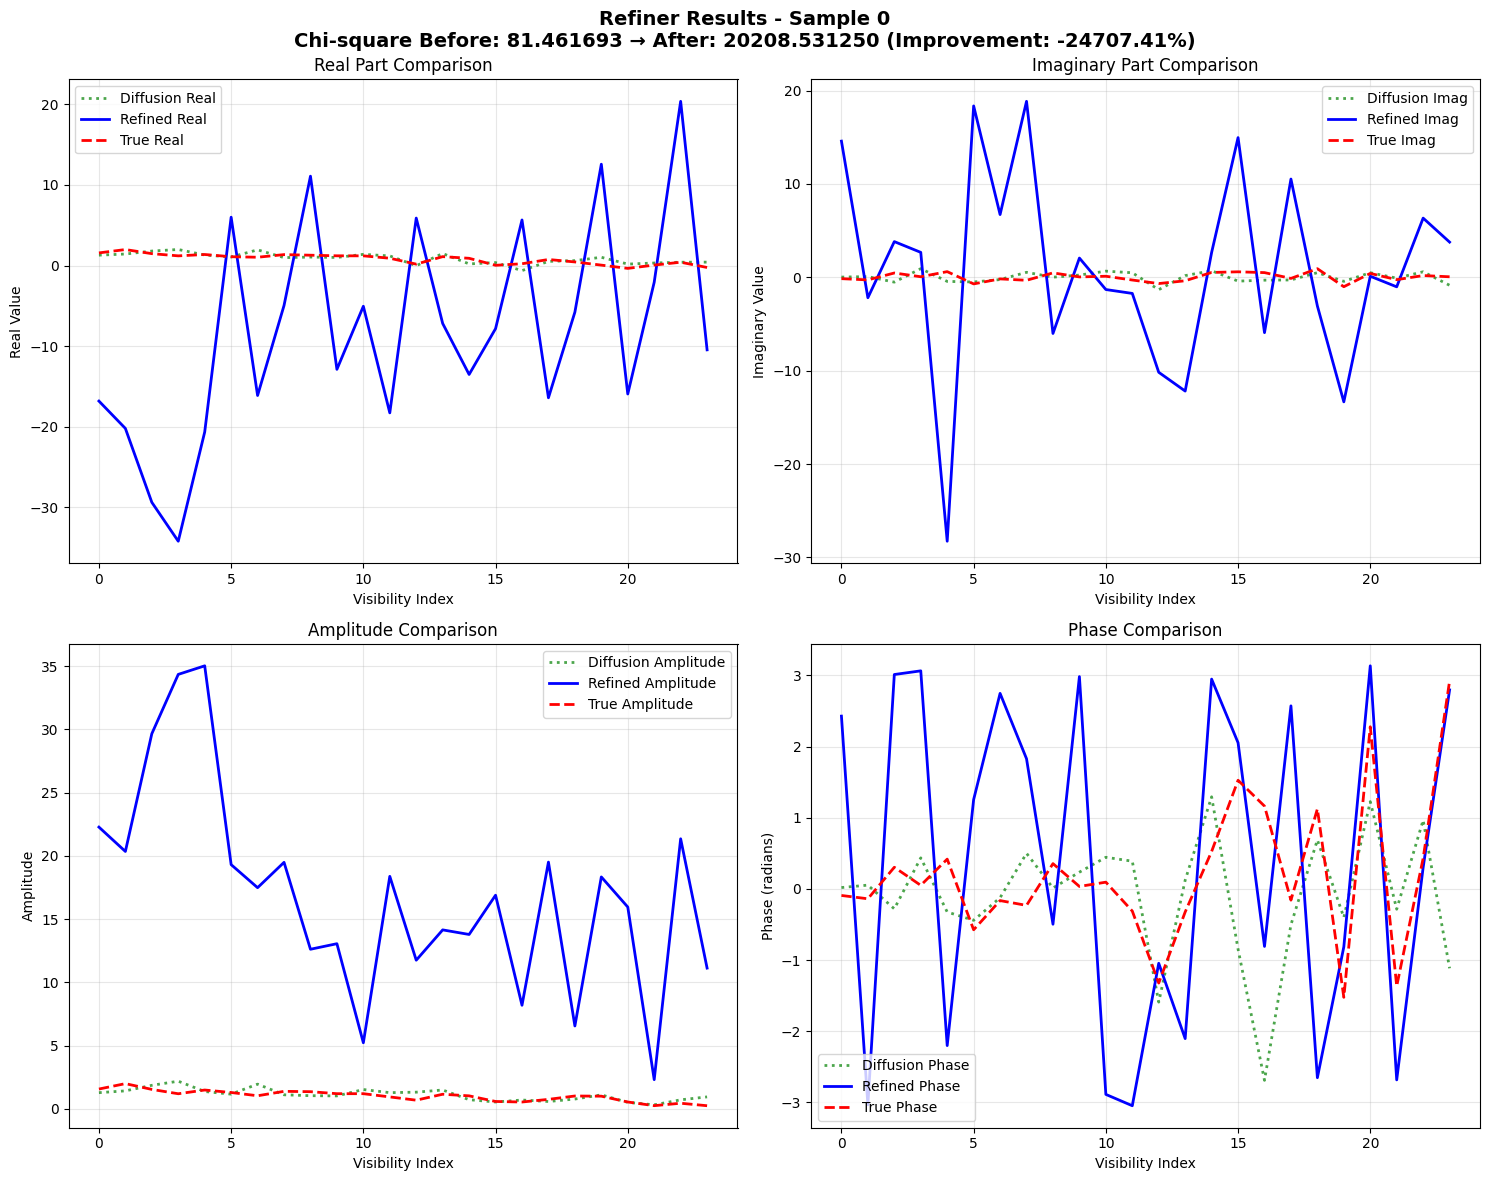

In [39]:
# Plot comparison between diffusion, refined, and true visibilities
sample_idx = 0
pred_vis_np = predicted_vis[sample_idx].cpu().numpy()
refined_vis_np = refined_vis[sample_idx].cpu().numpy()
true_vis_np = true_vis_reshaped[sample_idx].cpu().numpy()

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot real parts
axes[0, 0].plot(pred_vis_np[:, 0], 'g:', label='Diffusion Real', linewidth=2, alpha=0.7)
axes[0, 0].plot(refined_vis_np[:, 0], 'b-', label='Refined Real', linewidth=2)
axes[0, 0].plot(true_vis_np[:, 0], 'r--', label='True Real', linewidth=2)
axes[0, 0].set_title('Real Part Comparison')
axes[0, 0].set_xlabel('Visibility Index')
axes[0, 0].set_ylabel('Real Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot imaginary parts
axes[0, 1].plot(pred_vis_np[:, 1], 'g:', label='Diffusion Imag', linewidth=2, alpha=0.7)
axes[0, 1].plot(refined_vis_np[:, 1], 'b-', label='Refined Imag', linewidth=2)
axes[0, 1].plot(true_vis_np[:, 1], 'r--', label='True Imag', linewidth=2)
axes[0, 1].set_title('Imaginary Part Comparison')
axes[0, 1].set_xlabel('Visibility Index')
axes[0, 1].set_ylabel('Imaginary Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot amplitude comparison
pred_amp = np.sqrt(pred_vis_np[:, 0]**2 + pred_vis_np[:, 1]**2)
refined_amp = np.sqrt(refined_vis_np[:, 0]**2 + refined_vis_np[:, 1]**2)
true_amp = np.sqrt(true_vis_np[:, 0]**2 + true_vis_np[:, 1]**2)

axes[1, 0].plot(pred_amp, 'g:', label='Diffusion Amplitude', linewidth=2, alpha=0.7)
axes[1, 0].plot(refined_amp, 'b-', label='Refined Amplitude', linewidth=2)
axes[1, 0].plot(true_amp, 'r--', label='True Amplitude', linewidth=2)
axes[1, 0].set_title('Amplitude Comparison')
axes[1, 0].set_xlabel('Visibility Index')
axes[1, 0].set_ylabel('Amplitude')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot phase comparison
pred_phase = np.arctan2(pred_vis_np[:, 1], pred_vis_np[:, 0])
refined_phase = np.arctan2(refined_vis_np[:, 1], refined_vis_np[:, 0])
true_phase = np.arctan2(true_vis_np[:, 1], true_vis_np[:, 0])

axes[1, 1].plot(pred_phase, 'g:', label='Diffusion Phase', linewidth=2, alpha=0.7)
axes[1, 1].plot(refined_phase, 'b-', label='Refined Phase', linewidth=2)
axes[1, 1].plot(true_phase, 'r--', label='True Phase', linewidth=2)
axes[1, 1].set_title('Phase Comparison')
axes[1, 1].set_xlabel('Visibility Index')
axes[1, 1].set_ylabel('Phase (radians)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Add overall title with chi-square distances
fig.suptitle(f'Refiner Results - Sample {sample_idx}\n'
            f'Chi-square Before: {chi_sq_before:.6f} → After: {chi_sq_after:.6f} '
            f'(Improvement: {improvement:.2f}%)', 
            fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## FCD Model Wrapper

In [14]:
class FCDModelWrapper:
    """Wrapper for the FCD (Fourier Convolutional Decoder) model."""
    
    def __init__(self, model_path=None, backend="tensorflow", download_dir=None):
        if not KERAS_AVAILABLE:
            raise ImportError("Keras is required for FCD model")
        
        # Set Keras backend if specified
        if backend != os.environ.get("KERAS_BACKEND", "tensorflow"):
            os.environ["KERAS_BACKEND"] = backend
            print(f"Keras backend set to: {backend}")
        
        # Load the FCD model
        if model_path is None or model_path == "hf://mervess/FCD-Solar":
            # Download from HuggingFace hub
            try:
                print("Downloading FCD model from HuggingFace hub...")
                
                # Set download directory if specified
                if download_dir:
                    os.makedirs(download_dir, exist_ok=True)
                    local_model_path = huggingface_hub.snapshot_download(
                        "mervess/FCD-Solar",
                        cache_dir=download_dir
                    )
                    print(f"Model downloaded to: {local_model_path}")
                else:
                    local_model_path = huggingface_hub.snapshot_download("mervess/FCD-Solar")
                    print(f"Model downloaded to default cache: {local_model_path}")
                
                # Look for the actual .keras file in the downloaded directory
                keras_file = os.path.join(local_model_path, "fcd.keras")
                filters_file = os.path.join(local_model_path, "filters.py")
                
                if os.path.exists(keras_file) and os.path.exists(filters_file):
                    # Import GaussianFilter from the downloaded filters.py
                    import sys
                    sys.path.insert(0, local_model_path)
                    try:
                        from filters import GaussianFilter
                        custom_objects = {'GaussianFilter': GaussianFilter}
                        self.model = keras.saving.load_model(keras_file, custom_objects=custom_objects, compile=False)
                        print(f"Loaded FCD model from: {keras_file}")
                    finally:
                        sys.path.remove(local_model_path)
                else:
                    raise FileNotFoundError(f"Required files not found: {keras_file} or {filters_file}")
                print("✅ FCD model loaded successfully from HuggingFace")
                
            except Exception as e:
                print(f"Failed to download/load FCD model from HuggingFace: {e}")
                raise
        else:
            # Load from local path
            if not os.path.exists(model_path):
                raise FileNotFoundError(f"FCD model not found at: {model_path}")
            
            # Look for filters.py in the same directory
            model_dir = os.path.dirname(model_path)
            filters_file = os.path.join(model_dir, "filters.py")
            
            if os.path.exists(filters_file):
                # Import GaussianFilter from filters.py
                import sys
                sys.path.insert(0, model_dir)
                try:
                    from filters import GaussianFilter
                    custom_objects = {'GaussianFilter': GaussianFilter}
                    self.model = keras.saving.load_model(model_path, custom_objects=custom_objects, compile=False)
                finally:
                    sys.path.remove(model_dir)
            else:
                # Try loading without custom objects
                self.model = keras.saving.load_model(model_path, compile=False)
            
            print(f"FCD model loaded from: {model_path}")
        
    def predict(self, visibilities):
        """
        Predict images from visibilities.
        
        Args:
            visibilities: Array of shape (batch_size, 24, 2) - complex visibilities
            
        Returns:
            reconstructed_images: Array of shape (batch_size, 128, 128, 1)
        """
        # Convert complex visibilities to FCD input format (48 real numbers)
        if isinstance(visibilities, torch.Tensor):
            visibilities = visibilities.detach().cpu().numpy()
            
        batch_size = visibilities.shape[0]
        fcd_input = visibilities.reshape(batch_size, -1)  # (batch_size, 48)
        
        # Predict using FCD model
        reconstructed_images = self.model.predict(fcd_input, verbose=0)
        
        return reconstructed_images

print("✅ FCD Model Wrapper defined")

✅ FCD Model Wrapper defined


## Load FCD Model

In [15]:
# Load FCD model
fcd_model = None

if KERAS_AVAILABLE:
    try:
        print("Loading FCD model from HuggingFace...")
        fcd_model = FCDModelWrapper(
            model_path=None,  # This will download from HuggingFace
            backend="tensorflow",
            download_dir="/tmp/fcd_cache"  # Optional: specify download directory
        )
        print("✅ FCD model loaded successfully")
        print(f"FCD model input shape: {fcd_model.model.input.shape}")
        print(f"FCD model output shape: {fcd_model.model.output.shape}")
        
    except Exception as e:
        print(f"⚠️ Warning: Could not load FCD model: {e}")
        print("Continuing without FCD model (no image reconstruction)")
        fcd_model = None
else:
    print("⚠️ Keras not available, skipping FCD model loading")

Loading FCD model from HuggingFace...


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

filters.py: 0.00B [00:00, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

20211216_vis.sav:   0%|          | 0.00/5.22k [00:00<?, ?B/s]

fcd_demo.ipynb: 0.00B [00:00, ?B/s]

README.md: 0.00B [00:00, ?B/s]

co2_eq.png:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

model_arch.png:   0%|          | 0.00/47.9k [00:00<?, ?B/s]

20211216_vis.npy:   0%|          | 0.00/320 [00:00<?, ?B/s]

fcd.keras:   0%|          | 0.00/11.7M [00:00<?, ?B/s]

framework.png:   0%|          | 0.00/216k [00:00<?, ?B/s]

Model downloaded to: /tmp/fcd_cache/models--mervess--FCD-Solar/snapshots/e7565951d65c92c61eaa72ba569b6c37a7cd7908
Loaded FCD model from: /tmp/fcd_cache/models--mervess--FCD-Solar/snapshots/e7565951d65c92c61eaa72ba569b6c37a7cd7908/fcd.keras
✅ FCD model loaded successfully from HuggingFace
✅ FCD model loaded successfully
FCD model input shape: (None, 48)
FCD model output shape: (None, 128, 128, 1)


## Generate Images with FCD Model

In [40]:
if fcd_model is not None:
    print("Generating images with FCD model...")
    
    # Generate images from different visibility types
    with torch.no_grad():
        # Original diffusion visibilities
        diffusion_images = fcd_model.predict(predicted_vis)
        
        # Refined visibilities
        refined_images = fcd_model.predict(refined_vis)
        
        # Ground truth visibilities
        gt_images = fcd_model.predict(true_vis_reshaped)
        
    print(f"✅ Generated images:")
    print(f"  Diffusion images shape: {diffusion_images.shape}")
    print(f"  Refined images shape: {refined_images.shape}")
    print(f"  Ground truth images shape: {gt_images.shape}")
    
    # Calculate image quality metrics
    def calculate_image_metrics(pred_img, true_img):
        mse = np.mean((pred_img - true_img)**2)
        mae = np.mean(np.abs(pred_img - true_img))
        return mse, mae
    
    diff_mse, diff_mae = calculate_image_metrics(diffusion_images[0], gt_images[0])
    ref_mse, ref_mae = calculate_image_metrics(refined_images[0], gt_images[0])
    
    print(f"\nImage Quality Metrics (Sample 0):")
    print(f"Diffusion → FCD - MSE: {diff_mse:.6f}, MAE: {diff_mae:.6f}")
    print(f"Refined → FCD  - MSE: {ref_mse:.6f}, MAE: {ref_mae:.6f}")
    print(f"Image improvement: {((diff_mse - ref_mse) / diff_mse * 100):.2f}% (MSE)")
else:
    print("⚠️ FCD model not available, skipping image generation")
    diffusion_images = None
    refined_images = None
    gt_images = None

Generating images with FCD model...
✅ Generated images:
  Diffusion images shape: (8, 128, 128, 1)
  Refined images shape: (8, 128, 128, 1)
  Ground truth images shape: (8, 128, 128, 1)

Image Quality Metrics (Sample 0):
Diffusion → FCD - MSE: 0.000000, MAE: 0.000009
Refined → FCD  - MSE: 0.000000, MAE: 0.000020
Image improvement: -696.69% (MSE)


## Comprehensive Image Comparison

In [18]:
diffusion_images.shape[0]

8

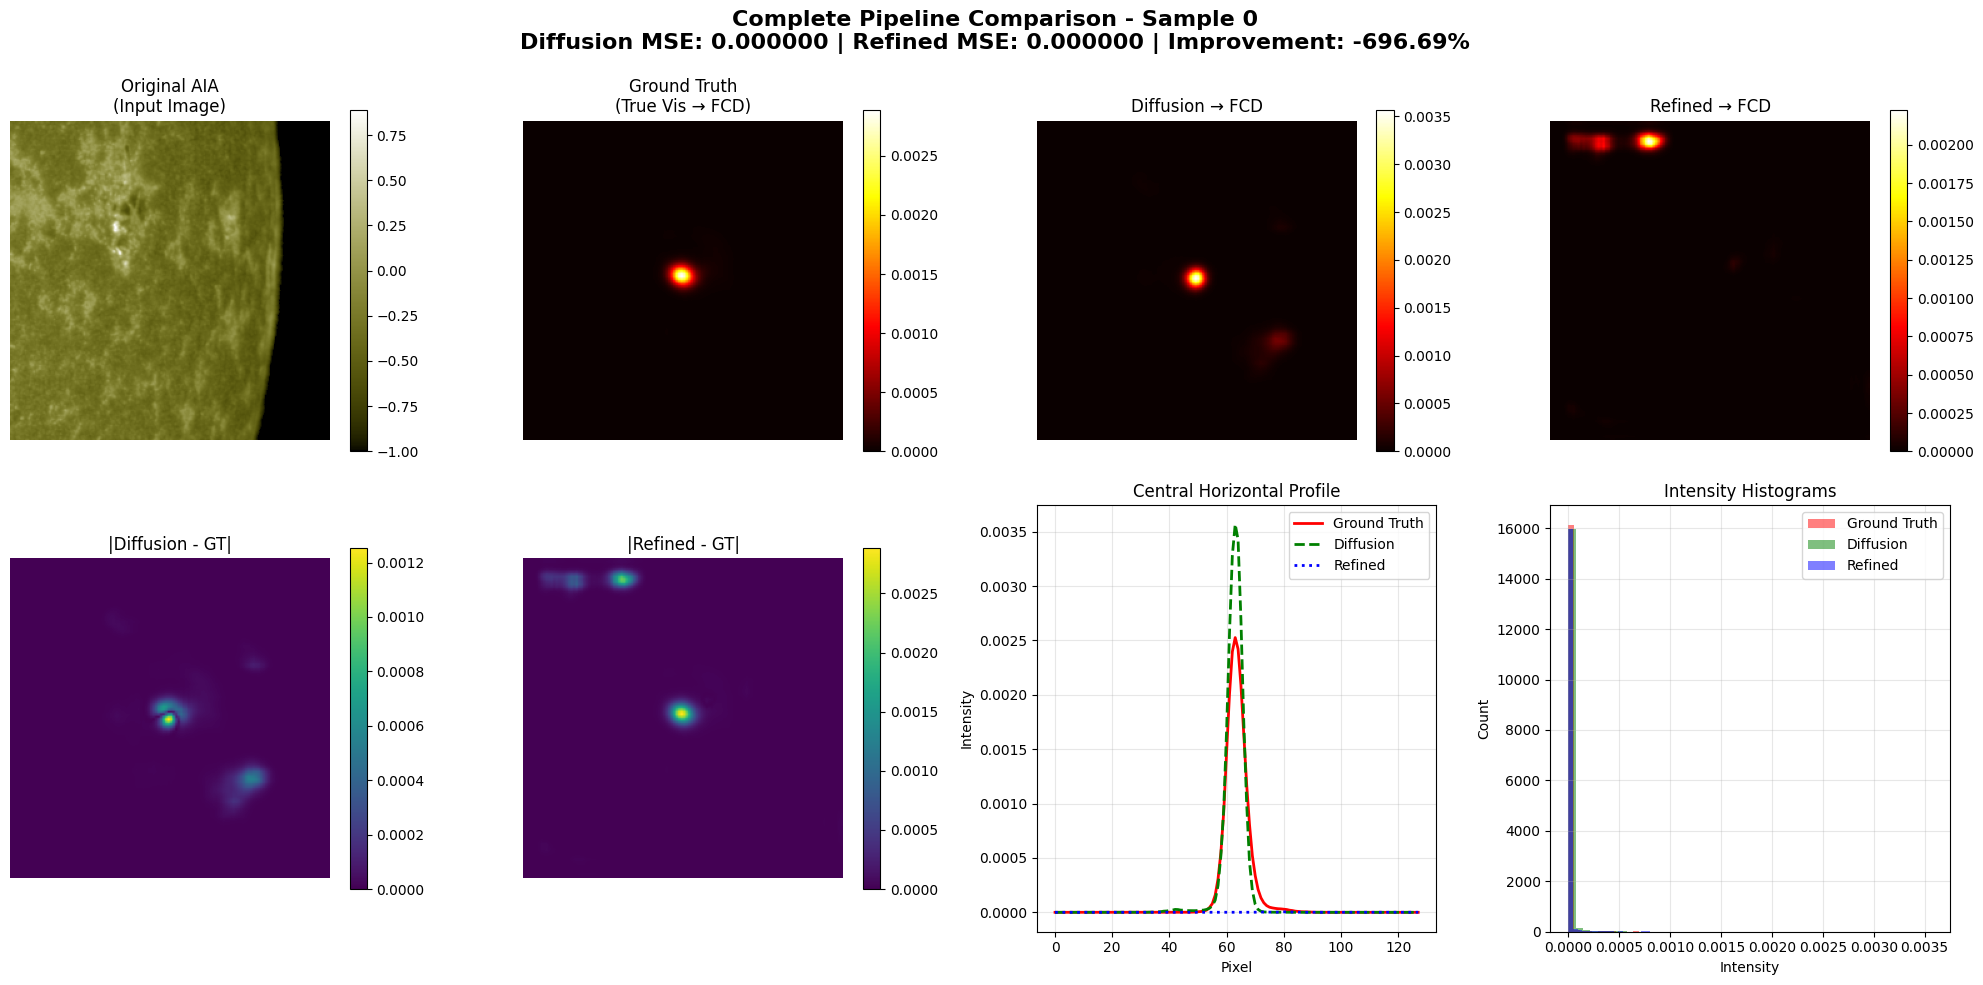

Sample 0 Metrics:
  Diffusion → FCD: MSE=0.000000, MAE=0.000009
  Refined → FCD:   MSE=0.000000, MAE=0.000020
  Improvement:     -696.69% (MSE)



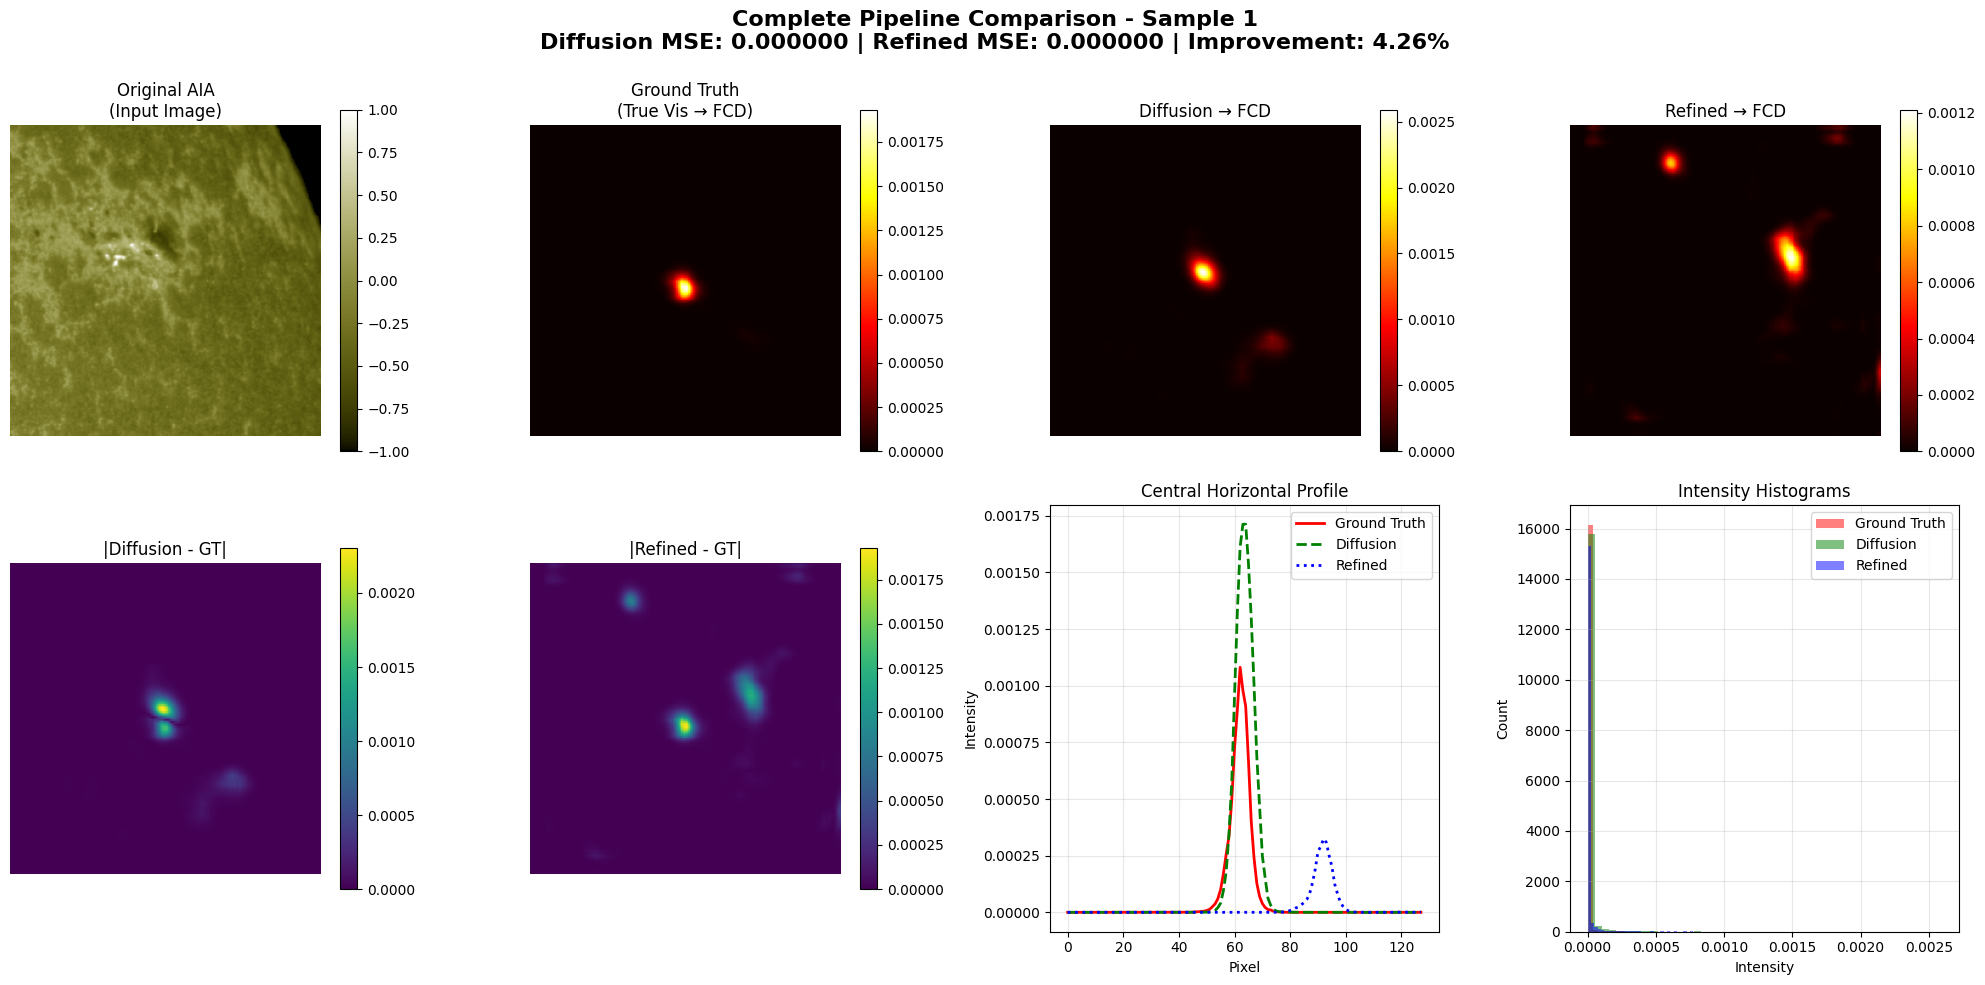

Sample 1 Metrics:
  Diffusion → FCD: MSE=0.000000, MAE=0.000016
  Refined → FCD:   MSE=0.000000, MAE=0.000021
  Improvement:     4.26% (MSE)



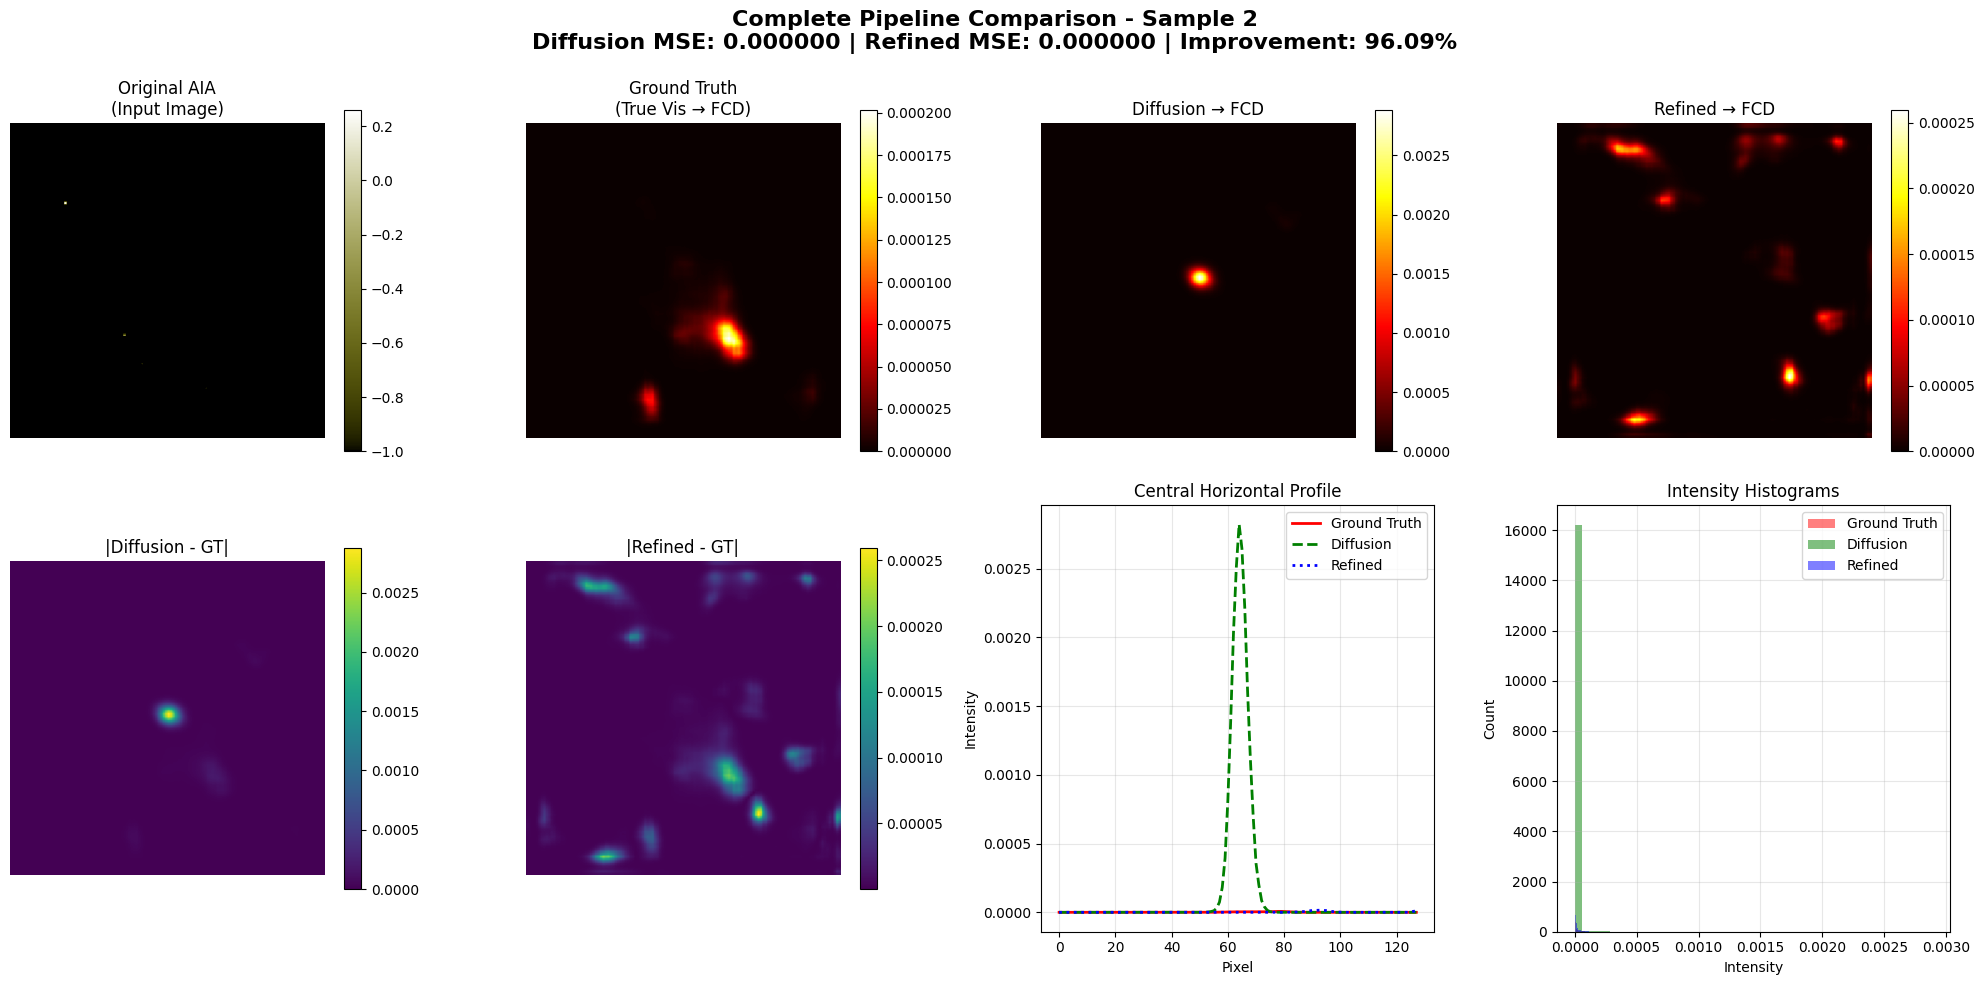

Sample 2 Metrics:
  Diffusion → FCD: MSE=0.000000, MAE=0.000010
  Refined → FCD:   MSE=0.000000, MAE=0.000006
  Improvement:     96.09% (MSE)



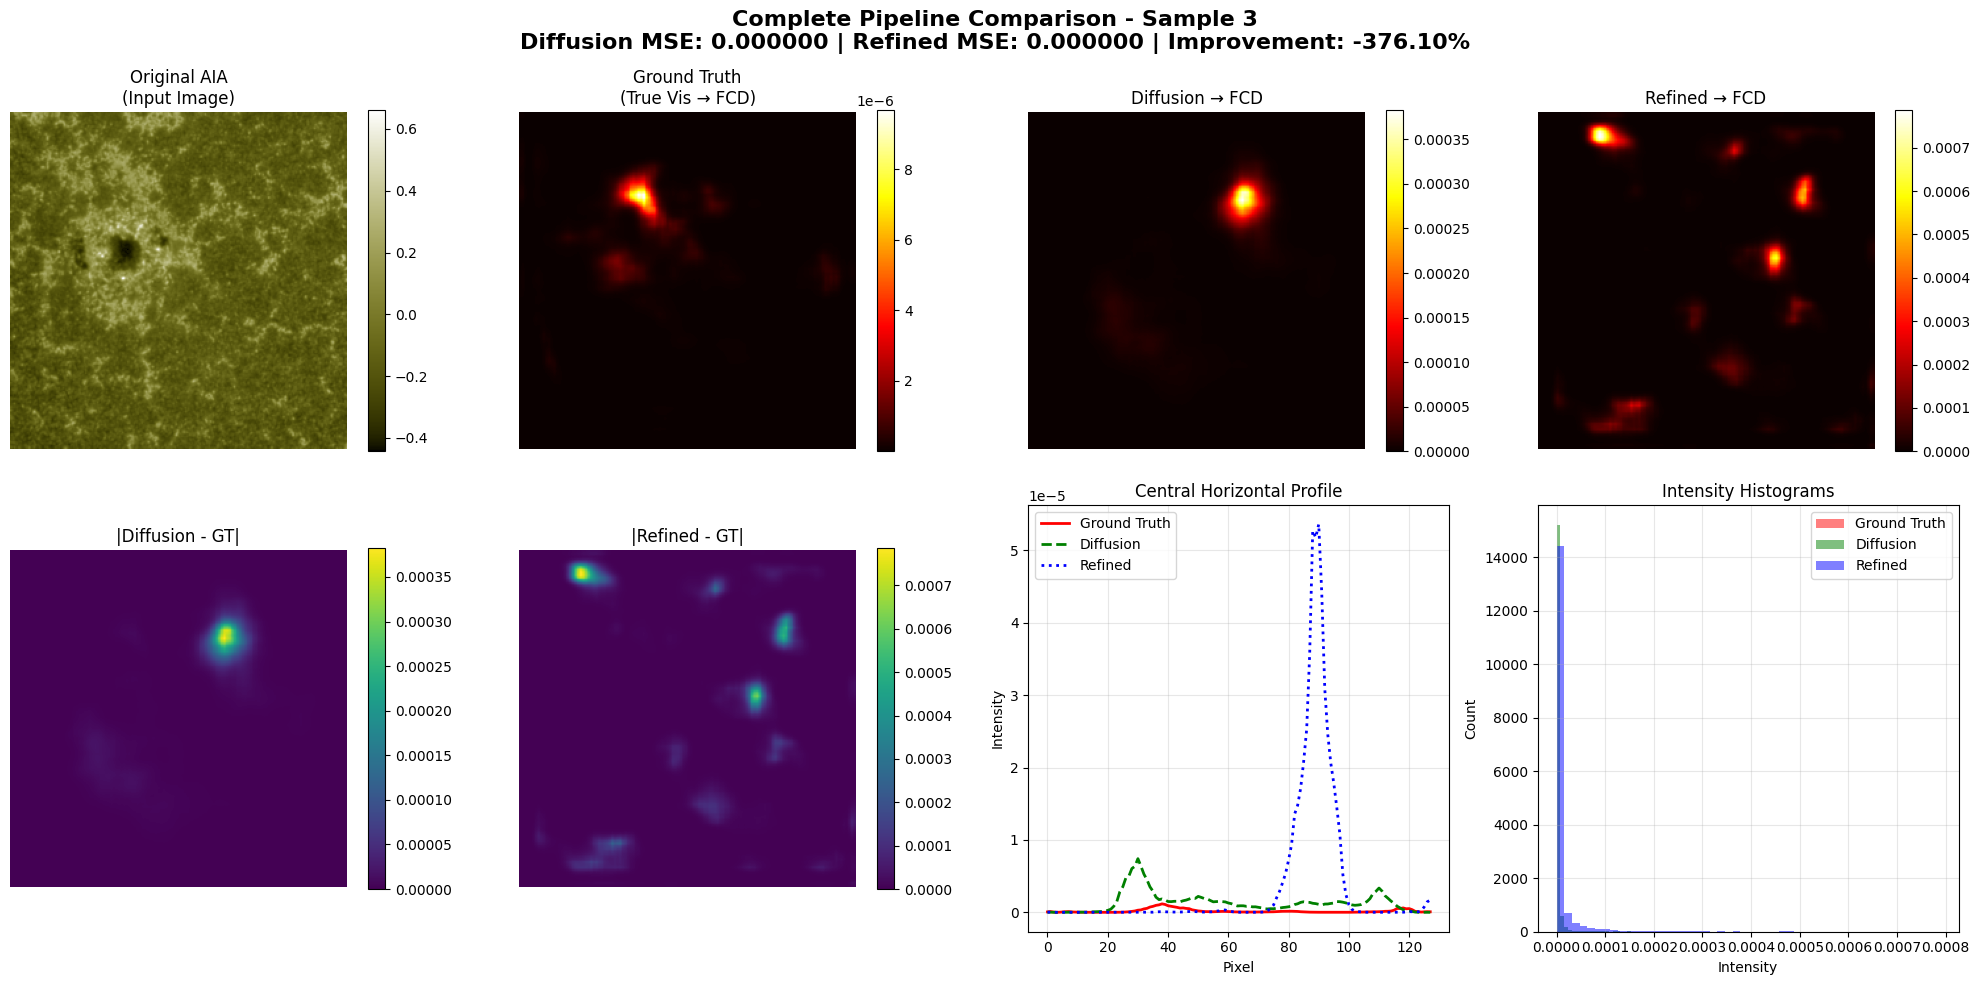

Sample 3 Metrics:
  Diffusion → FCD: MSE=0.000000, MAE=0.000004
  Refined → FCD:   MSE=0.000000, MAE=0.000012
  Improvement:     -376.10% (MSE)



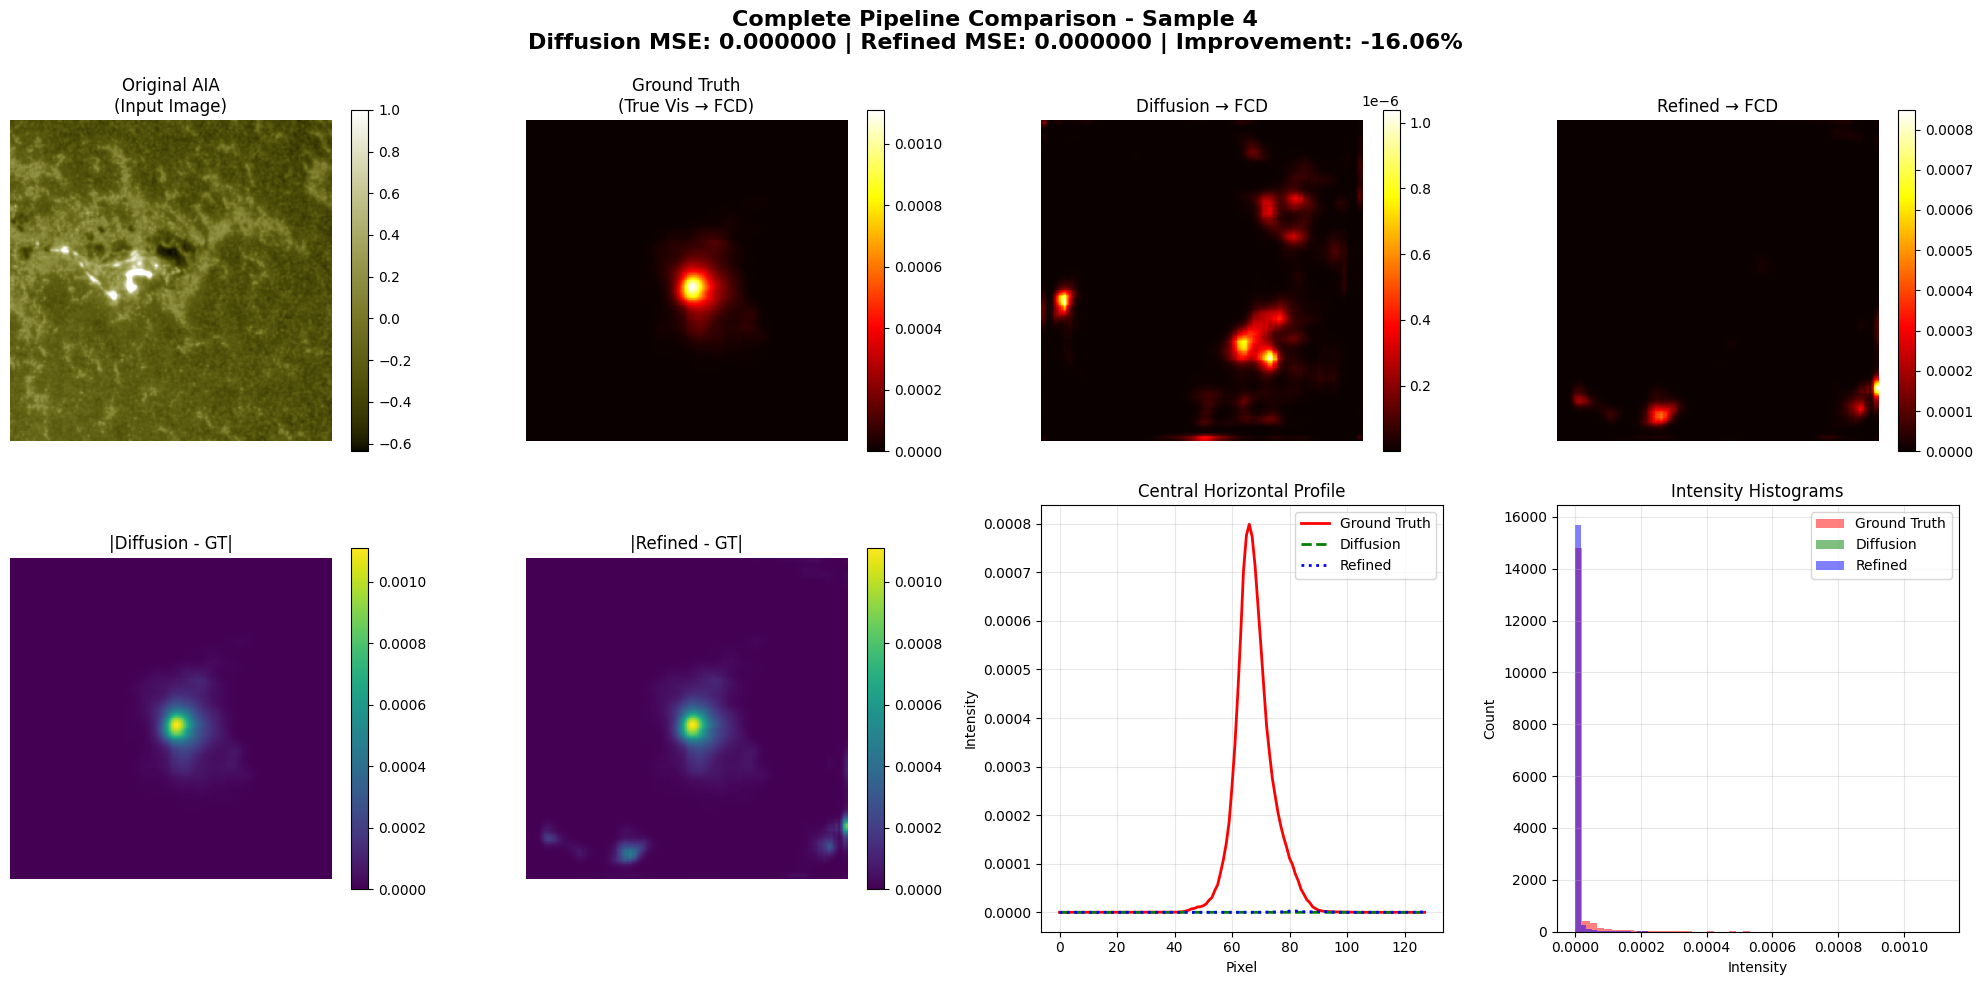

Sample 4 Metrics:
  Diffusion → FCD: MSE=0.000000, MAE=0.000015
  Refined → FCD:   MSE=0.000000, MAE=0.000019
  Improvement:     -16.06% (MSE)



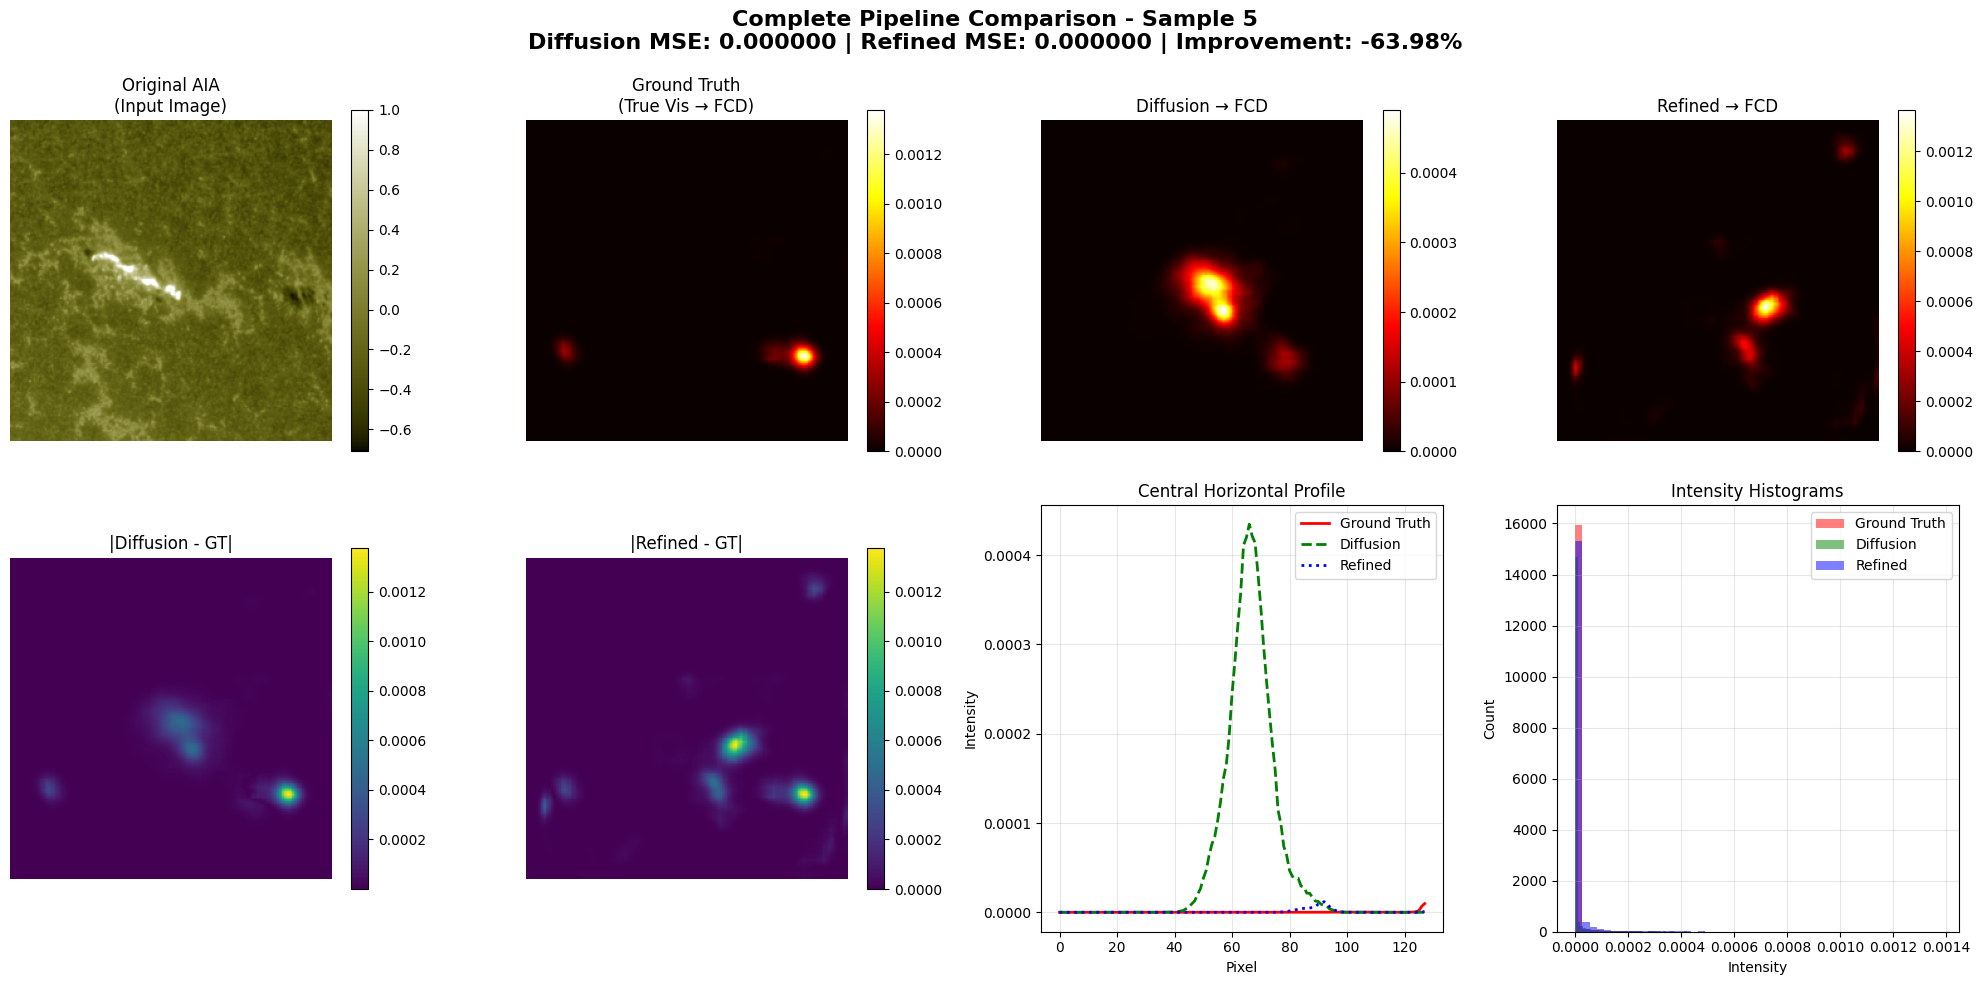

Sample 5 Metrics:
  Diffusion → FCD: MSE=0.000000, MAE=0.000015
  Refined → FCD:   MSE=0.000000, MAE=0.000019
  Improvement:     -63.98% (MSE)



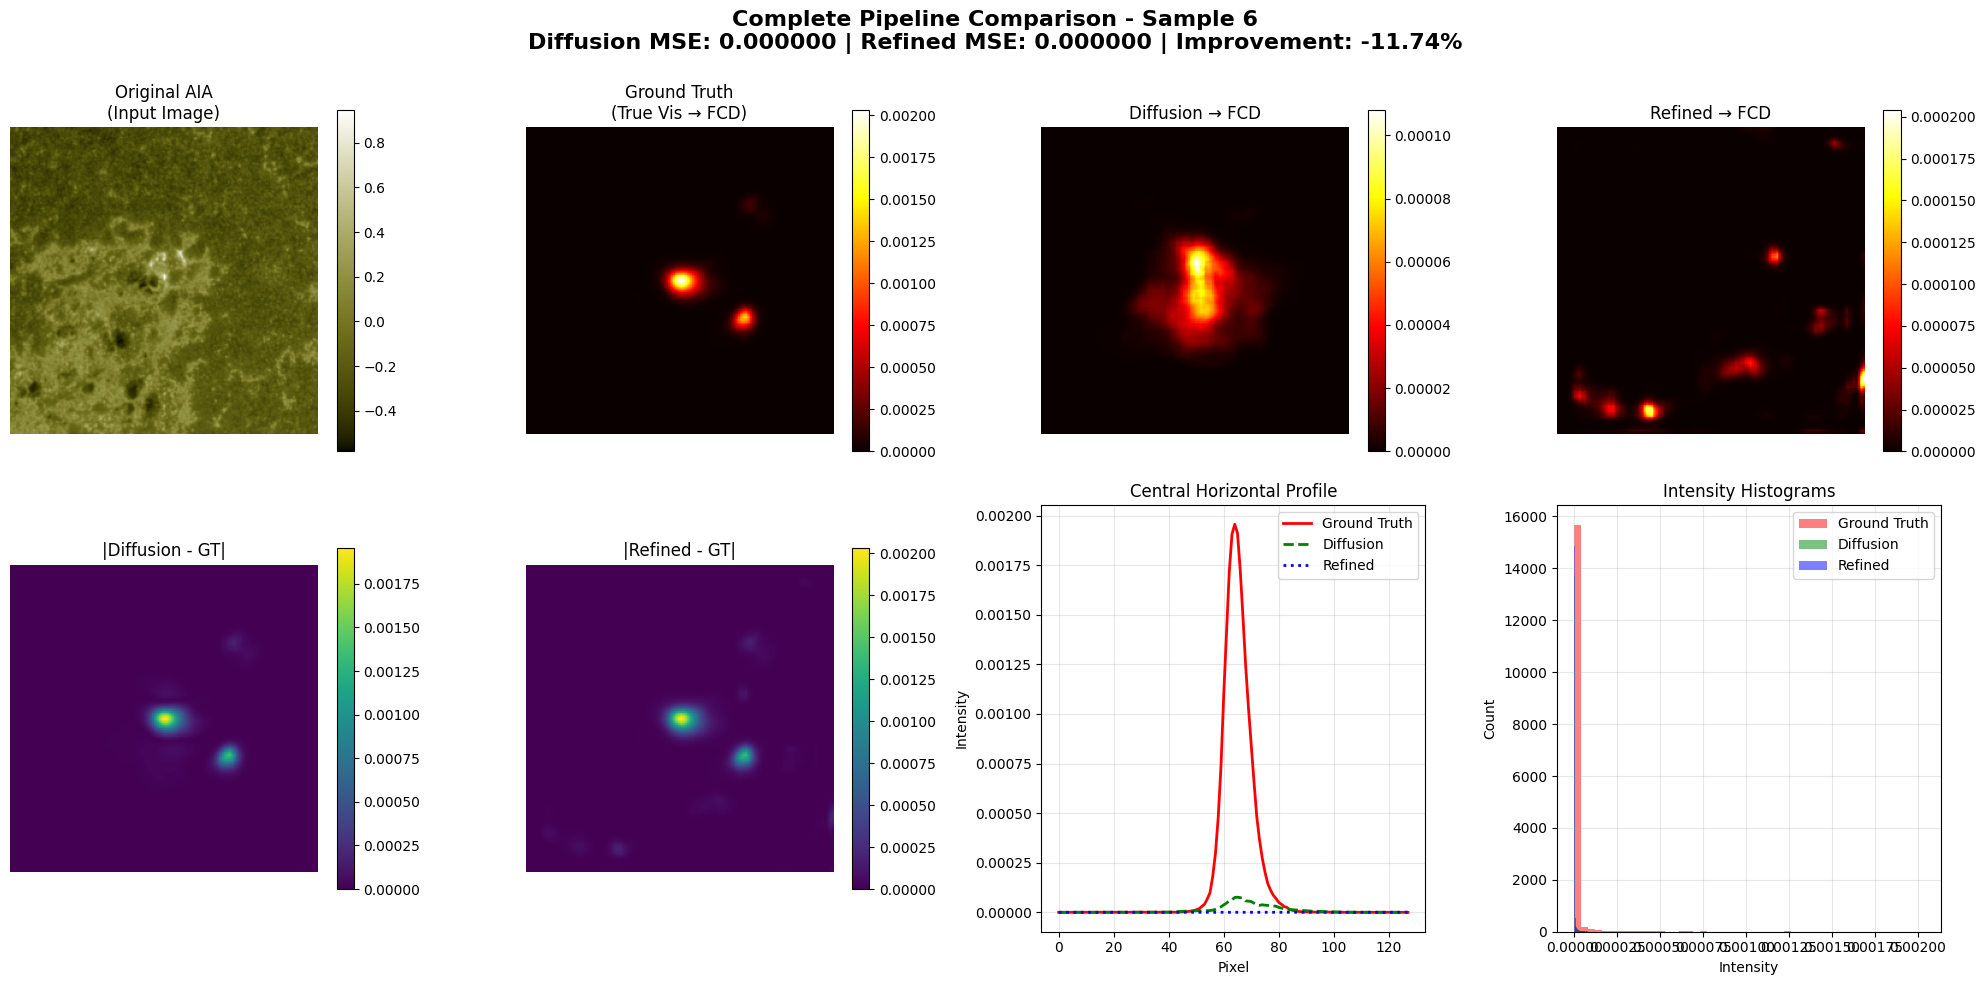

Sample 6 Metrics:
  Diffusion → FCD: MSE=0.000000, MAE=0.000016
  Refined → FCD:   MSE=0.000000, MAE=0.000019
  Improvement:     -11.74% (MSE)



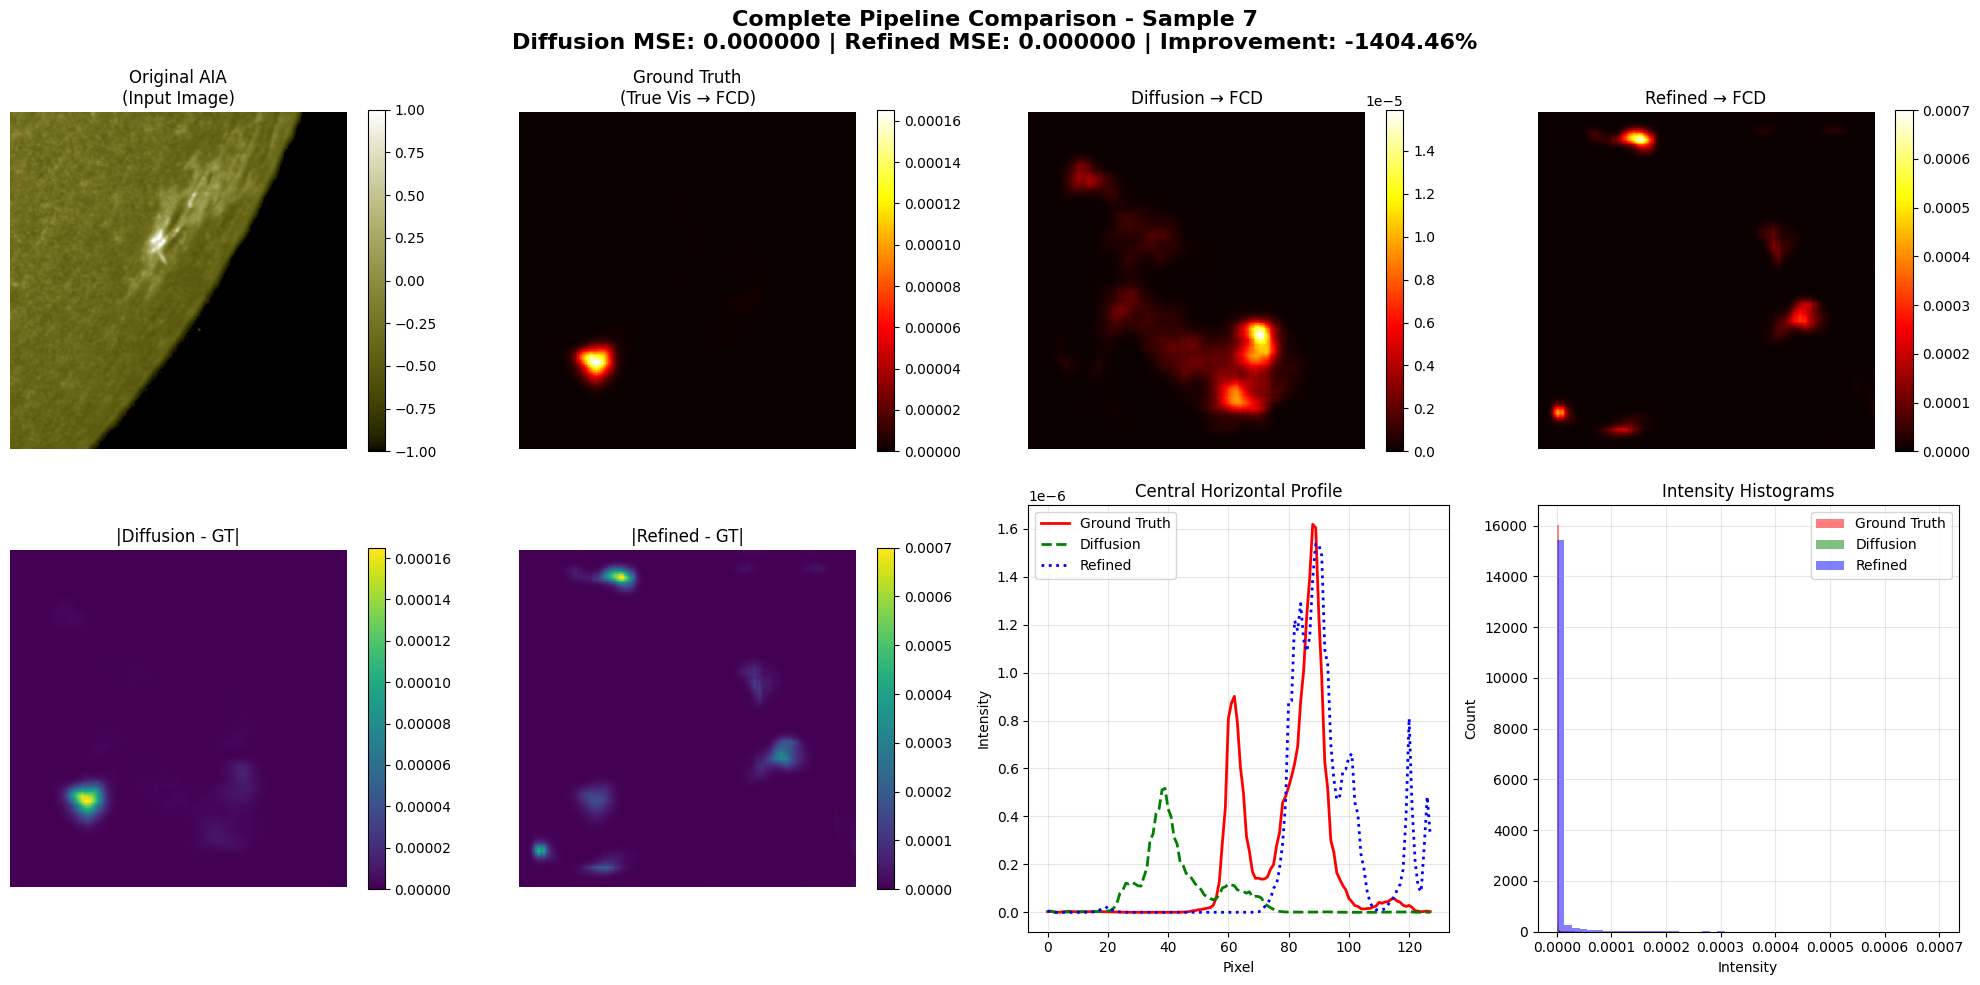

Sample 7 Metrics:
  Diffusion → FCD: MSE=0.000000, MAE=0.000001
  Refined → FCD:   MSE=0.000000, MAE=0.000007
  Improvement:     -1404.46% (MSE)



In [42]:
if fcd_model is not None and diffusion_images is not None:
    # Plot comprehensive comparison for multiple samples
    num_samples_to_plot = max(3, diffusion_images.shape[0])
    
    for sample_idx in range(num_samples_to_plot):
        # Get images for this sample
        aia_img = aia_data[sample_idx].cpu().numpy()
        diff_img = diffusion_images[sample_idx]
        ref_img = refined_images[sample_idx]
        gt_img = gt_images[sample_idx]
        
        # Create comprehensive plot
        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        
        # First row: Images
        # Original AIA image
        try:
            sdoaia1600 = matplotlib.colormaps['sdoaia1600']
        except KeyError:
            sdoaia1600 = 'hot'  # Fallback colormap
            
        aia_display = aia_img[0] if len(aia_img.shape) > 2 else aia_img
        im0 = axes[0, 0].imshow(aia_display.squeeze(), cmap=sdoaia1600, origin='lower')
        axes[0, 0].set_title('Original AIA\n(Input Image)')
        axes[0, 0].axis('off')
        plt.colorbar(im0, ax=axes[0, 0], shrink=0.8)
        
        # Ground truth image
        im1 = axes[0, 1].imshow(gt_img.squeeze(), cmap='hot', origin='lower')
        axes[0, 1].set_title('Ground Truth\n(True Vis → FCD)')
        axes[0, 1].axis('off')
        plt.colorbar(im1, ax=axes[0, 1], shrink=0.8)
        
        # Diffusion generated image
        im2 = axes[0, 2].imshow(diff_img.squeeze(), cmap='hot', origin='lower')
        axes[0, 2].set_title('Diffusion → FCD')
        axes[0, 2].axis('off')
        plt.colorbar(im2, ax=axes[0, 2], shrink=0.8)
        
        # Refined image
        im3 = axes[0, 3].imshow(ref_img.squeeze(), cmap='hot', origin='lower')
        axes[0, 3].set_title('Refined → FCD')
        axes[0, 3].axis('off')
        plt.colorbar(im3, ax=axes[0, 3], shrink=0.8)
        
        # Second row: Differences and profiles
        # Difference: Diffusion vs GT
        diff_error = np.abs(diff_img - gt_img)
        im4 = axes[1, 0].imshow(diff_error.squeeze(), cmap='viridis', origin='lower')
        axes[1, 0].set_title('|Diffusion - GT|')
        axes[1, 0].axis('off')
        plt.colorbar(im4, ax=axes[1, 0], shrink=0.8)
        
        # Difference: Refined vs GT
        ref_error = np.abs(ref_img - gt_img)
        im5 = axes[1, 1].imshow(ref_error.squeeze(), cmap='viridis', origin='lower')
        axes[1, 1].set_title('|Refined - GT|')
        axes[1, 1].axis('off')
        plt.colorbar(im5, ax=axes[1, 1], shrink=0.8)
        
        # Central profile comparison
        center = gt_img.shape[0] // 2
        axes[1, 2].plot(gt_img[center, :].squeeze(), 'r-', label='Ground Truth', linewidth=2)
        axes[1, 2].plot(diff_img[center, :].squeeze(), 'g--', label='Diffusion', linewidth=2)
        axes[1, 2].plot(ref_img[center, :].squeeze(), 'b:', label='Refined', linewidth=2)
        axes[1, 2].set_title('Central Horizontal Profile')
        axes[1, 2].set_xlabel('Pixel')
        axes[1, 2].set_ylabel('Intensity')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        
        # Histogram comparison
        axes[1, 3].hist(gt_img.flatten(), bins=50, alpha=0.5, label='Ground Truth', color='red')
        axes[1, 3].hist(diff_img.flatten(), bins=50, alpha=0.5, label='Diffusion', color='green')
        axes[1, 3].hist(ref_img.flatten(), bins=50, alpha=0.5, label='Refined', color='blue')
        axes[1, 3].set_title('Intensity Histograms')
        axes[1, 3].set_xlabel('Intensity')
        axes[1, 3].set_ylabel('Count')
        axes[1, 3].legend()
        axes[1, 3].grid(True, alpha=0.3)
        
        # Calculate and display metrics
        diff_mse, diff_mae = calculate_image_metrics(diff_img, gt_img)
        ref_mse, ref_mae = calculate_image_metrics(ref_img, gt_img)
        
        fig.suptitle(f'Complete Pipeline Comparison - Sample {sample_idx}\n'
                    f'Diffusion MSE: {diff_mse:.6f} | Refined MSE: {ref_mse:.6f} | '
                    f'Improvement: {((diff_mse - ref_mse) / diff_mse * 100):.2f}%',
                    fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"Sample {sample_idx} Metrics:")
        print(f"  Diffusion → FCD: MSE={diff_mse:.6f}, MAE={diff_mae:.6f}")
        print(f"  Refined → FCD:   MSE={ref_mse:.6f}, MAE={ref_mae:.6f}")
        print(f"  Improvement:     {((diff_mse - ref_mse) / diff_mse * 100):.2f}% (MSE)")
        print()
else:
    print("⚠️ FCD model not available, skipping comprehensive image comparison")

## Summary Statistics

In [19]:
print("=" * 80)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("=" * 80)

# Visibility statistics
print("\n🔹 VISIBILITY PREDICTION PERFORMANCE:")
print(f"Batch size: {predicted_vis.shape[0]} samples")

# Calculate statistics for all samples
chi_sq_before_all = []
chi_sq_after_all = []
mse_before_all = []
mse_after_all = []

for i in range(min(NUM_SAMPLES, predicted_vis.shape[0])):
    chi_sq_b = chi_square_distance(predicted_vis[i], true_vis_reshaped[i])
    chi_sq_a = chi_square_distance(refined_vis[i], true_vis_reshaped[i])
    mse_b = F.mse_loss(predicted_vis[i:i+1], true_vis_reshaped[i:i+1]).item()
    mse_a = F.mse_loss(refined_vis[i:i+1], true_vis_reshaped[i:i+1]).item()
    
    chi_sq_before_all.append(chi_sq_b)
    chi_sq_after_all.append(chi_sq_a)
    mse_before_all.append(mse_b)
    mse_after_all.append(mse_a)

print(f"  Diffusion Model:")
print(f"    Chi-square: {np.mean(chi_sq_before_all):.6f} ± {np.std(chi_sq_before_all):.6f}")
print(f"    MSE:        {np.mean(mse_before_all):.6f} ± {np.std(mse_before_all):.6f}")

print(f"  After Refining:")
print(f"    Chi-square: {np.mean(chi_sq_after_all):.6f} ± {np.std(chi_sq_after_all):.6f}")
print(f"    MSE:        {np.mean(mse_after_all):.6f} ± {np.std(mse_after_all):.6f}")

avg_chi_improvement = np.mean([(b-a)/b*100 for b, a in zip(chi_sq_before_all, chi_sq_after_all)])
avg_mse_improvement = np.mean([(b-a)/b*100 for b, a in zip(mse_before_all, mse_after_all)])

print(f"  Average Improvement:")
print(f"    Chi-square: {avg_chi_improvement:.2f}%")
print(f"    MSE:        {avg_mse_improvement:.2f}%")

# Image reconstruction statistics (if available)
if fcd_model is not None and diffusion_images is not None:
    print("\n🔹 IMAGE RECONSTRUCTION PERFORMANCE:")
    
    img_mse_before_all = []
    img_mse_after_all = []
    img_mae_before_all = []
    img_mae_after_all = []
    
    for i in range(min(NUM_SAMPLES, diffusion_images.shape[0])):
        mse_b, mae_b = calculate_image_metrics(diffusion_images[i], gt_images[i])
        mse_a, mae_a = calculate_image_metrics(refined_images[i], gt_images[i])
        
        img_mse_before_all.append(mse_b)
        img_mse_after_all.append(mse_a)
        img_mae_before_all.append(mae_b)
        img_mae_after_all.append(mae_a)
    
    print(f"  Diffusion → FCD:")
    print(f"    MSE: {np.mean(img_mse_before_all):.6f} ± {np.std(img_mse_before_all):.6f}")
    print(f"    MAE: {np.mean(img_mae_before_all):.6f} ± {np.std(img_mae_before_all):.6f}")
    
    print(f"  Refined → FCD:")
    print(f"    MSE: {np.mean(img_mse_after_all):.6f} ± {np.std(img_mse_after_all):.6f}")
    print(f"    MAE: {np.mean(img_mae_after_all):.6f} ± {np.std(img_mae_after_all):.6f}")
    
    avg_img_mse_improvement = np.mean([(b-a)/b*100 for b, a in zip(img_mse_before_all, img_mse_after_all)])
    avg_img_mae_improvement = np.mean([(b-a)/b*100 for b, a in zip(img_mae_before_all, img_mae_after_all)])
    
    print(f"  Average Image Improvement:")
    print(f"    MSE: {avg_img_mse_improvement:.2f}%")
    print(f"    MAE: {avg_img_mae_improvement:.2f}%")

print("\n🔹 MODEL INFORMATION:")
print(f"  Diffusion model parameters: {sum(p.numel() for p in model_ema.parameters()):,}")
print(f"  Refiner model parameters:   {sum(p.numel() for p in refiner_model.parameters()):,}")
if fcd_model is not None:
    fcd_params = fcd_model.model.count_params()
    print(f"  FCD model parameters:       {fcd_params:,}")

print("\n🔹 CONFIGURATION:")
print(f"  Device: {device}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Samples evaluated: {min(NUM_SAMPLES, predicted_vis.shape[0])}")
print(f"  Refiner loss type: {refiner_config['loss']['type']}")
if refiner_config['loss']['type'] == 'composite':
    print(f"    Primary type: {refiner_config['loss']['primary_type']}")
    print(f"    Primary weight: {refiner_config['loss']['primary_weight']}")
    print(f"    Real/Imag weight: {refiner_config['loss']['real_imag_weight']}")

print("=" * 80)

COMPREHENSIVE EVALUATION SUMMARY

🔹 VISIBILITY PREDICTION PERFORMANCE:
Batch size: 8 samples
  Diffusion Model:
    Chi-square: 288.847778 ± 274.895782
    MSE:        0.873556 ± 0.172380
  After Refining:
    Chi-square: 25273.183594 ± 20797.568359
    MSE:        186.366515 ± 187.697308
  Average Improvement:
    Chi-square: -23334.34%
    MSE:        -26902.48%

🔹 IMAGE RECONSTRUCTION PERFORMANCE:
  Diffusion → FCD:
    MSE: 0.000000 ± 0.000000
    MAE: 0.000012 ± 0.000008
  Refined → FCD:
    MSE: 0.000000 ± 0.000000
    MAE: 0.000013 ± 0.000006
  Average Image Improvement:
    MSE: -83.83%
    MAE: -43.95%

🔹 MODEL INFORMATION:
  Diffusion model parameters: 30,443
  Refiner model parameters:   197,296
  FCD model parameters:       961,089

🔹 CONFIGURATION:
  Device: cpu
  Batch size: 8
  Samples evaluated: 5
  Refiner loss type: mse


## Evaluation on Multiple Batches (Optional)

In [22]:
# Optional: Run evaluation on multiple batches for more comprehensive statistics
EXTENDED_EVALUATION = True  # Set to True to run extended evaluation

if EXTENDED_EVALUATION:
    print("Running extended evaluation on multiple batches...")
    
    all_chi_sq_before = []
    all_chi_sq_after = []
    all_mse_before = []
    all_mse_after = []
    
    num_batches_to_eval = min(5, len(dataloader))  # Evaluate up to 5 batches
    
    for batch_idx, batch in enumerate(tqdm(dataloader, desc="Extended evaluation")):
        if batch_idx >= num_batches_to_eval:
            break
            
        # Process batch
        aia_data = batch[0].contiguous().float().to(device)
        true_vis = batch[1].to(device).reshape(-1, 1, 24, 2)
        enc_vis = batch[2].to(device).reshape(-1, 1, 24, 2)
        
        with torch.no_grad():
            # Generate with diffusion
            samples = generate_samples(
                model_ema, aia_data.shape[0], device,
                cond_label=None, sampler="dpmpp_2m_sde", cond_img=enc_vis
            )
            predicted_vis = samples.reshape(-1, 24, 2)
            true_vis_reshaped = true_vis.reshape(-1, 24, 2)
            
            # Refine
            diffusion_vis_flat = predicted_vis.view(-1, 48)
            refined_vis_flat = refiner_model(diffusion_vis_flat)
            refined_vis = refined_vis_flat.view(-1, 24, 2)
            
            # Calculate metrics for each sample in batch
            for i in range(predicted_vis.shape[0]):
                chi_sq_b = chi_square_distance(predicted_vis[i], true_vis_reshaped[i])
                chi_sq_a = chi_square_distance(refined_vis[i], true_vis_reshaped[i])
                mse_b = F.mse_loss(predicted_vis[i:i+1], true_vis_reshaped[i:i+1]).item()
                mse_a = F.mse_loss(refined_vis[i:i+1], true_vis_reshaped[i:i+1]).item()
                
                all_chi_sq_before.append(chi_sq_b)
                all_chi_sq_after.append(chi_sq_a)
                all_mse_before.append(mse_b)
                all_mse_after.append(mse_a)
    
    # Extended statistics
    print(f"\n🔹 EXTENDED EVALUATION RESULTS ({len(all_chi_sq_before)} samples):")
    print(f"  Diffusion Model:")
    print(f"    Chi-square: {np.mean(all_chi_sq_before):.6f} ± {np.std(all_chi_sq_before):.6f}")
    print(f"    MSE:        {np.mean(all_mse_before):.6f} ± {np.std(all_mse_before):.6f}")
    
    print(f"  After Refining:")
    print(f"    Chi-square: {np.mean(all_chi_sq_after):.6f} ± {np.std(all_chi_sq_after):.6f}")
    print(f"    MSE:        {np.mean(all_mse_after):.6f} ± {np.std(all_mse_after):.6f}")
    
    ext_chi_improvement = np.mean([(b-a)/b*100 for b, a in zip(all_chi_sq_before, all_chi_sq_after)])
    ext_mse_improvement = np.mean([(b-a)/b*100 for b, a in zip(all_mse_before, all_mse_after)])
    
    print(f"  Average Improvement:")
    print(f"    Chi-square: {ext_chi_improvement:.2f}%")
    print(f"    MSE:        {ext_mse_improvement:.2f}%")
else:
    print("Extended evaluation disabled. Set EXTENDED_EVALUATION = True to run.")

Running extended evaluation on multiple batches...


Extended evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/home2/francesco/.conda/envs/sdo_project/lib/python3.10/site-packages/torchsde/_brownian/brownian_interval.py:599: UserWarning: Should have ta>=t0 but got ta=0.009999996051192284 and t0=0.01.
  warnings.warn(f"Should have ta>=t0 but got ta={ta} and t0={self._start}.")
Extended evaluation:  14%|█▍        | 1/7 [00:00<00:02,  2.07it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Extended evaluation:  29%|██▊       | 2/7 [00:00<00:01,  3.44it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Extended evaluation:  43%|████▎     | 3/7 [00:00<00:00,  4.35it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Extended evaluation:  57%|█████▋    | 4/7 [00:00<00:00,  4.99it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Extended evaluation:  71%|███████▏  | 5/7 [00:01<00:00,  4.41it/s]


🔹 EXTENDED EVALUATION RESULTS (40 samples):
  Diffusion Model:
    Chi-square: 269.308990 ± 440.574249
    MSE:        0.913050 ± 0.383544
  After Refining:
    Chi-square: 58544.582031 ± 115669.781250
    MSE:        146.716016 ± 100.868407
  Average Improvement:
    Chi-square: -21970.08%
    MSE:        -20073.14%


## Conclusion

This notebook provides a comprehensive evaluation pipeline for the AIA2STIX diffusion model, visibility refiner, and FCD reconstruction model. 

Key capabilities:
1. **Diffusion Model Evaluation**: Generate visibilities from AIA images using the trained diffusion model
2. **Visibility Refinement**: Improve diffusion outputs using the trained refiner with composite loss
3. **Image Reconstruction**: Convert visibilities back to images using the FCD model
4. **Comprehensive Visualization**: Compare results at every stage of the pipeline
5. **Quantitative Metrics**: Chi-square distance, MSE, MAE for both visibilities and images

The composite loss function you implemented combines both primary loss (MSE or chi-square) with separate MSE losses for real and imaginary parts, providing more nuanced training that can improve both overall prediction quality and the specific handling of complex visibility components.